In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy import units as u
%config InlineBackend.figure_format = 'retina'
import pyneb as pn
import matplotlib
from scipy.ndimage import gaussian_filter1d
from matplotlib.colors import Normalize

In [2]:
c = const.c.cgs.value   
k_B = const.k_B.cgs.value  
m_p = const.m_p.cgs.value 

O3 = pn.Atom('O', 3)   # O3
H1 = pn.RecAtom('H', 1)  # H-beta


In [3]:

def getflux(ion, wl, T, ne, ni = None):
    if ni is None:
        ni = ne * 1e-4 # rough estimate from ISM densities

    eps = ion.getEmissivity(tem=T, den=ne, wave=wl)
    # emissivity per unit volume
    j = eps * ne * ni
    F = j #ignoring geometry and distance for now
    return F

# pure thermal broadening 
def broaden(wl0, T, mass):
    v_th = np.sqrt(2 * k_B * T / mass)
    return wl0 * (v_th / c)


In [4]:
def getgauss(wl, wl0, sigma, flux):
    amp = flux / (np.sqrt(2 * np.pi) * sigma)
    profile = amp * np.exp(- ((wl - wl0) / (2 * sigma))**2)
    return profile, amp

In [5]:
hex = np.loadtxt('fibers.csv', delimiter=',', skiprows=7, usecols=(5,6), max_rows=552)

x_arr, y_arr = hex[:,0], hex[:,1]

In [6]:
def los_vel(x, y, R, k):
    rho2 = x**2 + y**2
    inside = rho2 <= R**2

    # z on the shell for pixels that intersect it
    z = np.zeros_like(x, dtype=float)
    z[inside] = np.sqrt(R**2 - rho2[inside])   # near side (z > 0)

    # radial speed on the shell is k / R
    v_rad = k / R

    # v_los = v_rad * (z / R) = k * z / R^2
    v_near = np.zeros_like(x, dtype=float)
    v_near[inside] = v_rad * (z[inside] / R)

    v_far = -v_near 

    return v_near, v_far

In [7]:
nx, ny = 24, 24
R = 22  # shell radius in same units as x,y
k = 2000    # velocity scale (km/s * R_unit)
v_near, v_far = los_vel(x_arr, y_arr, R, k)


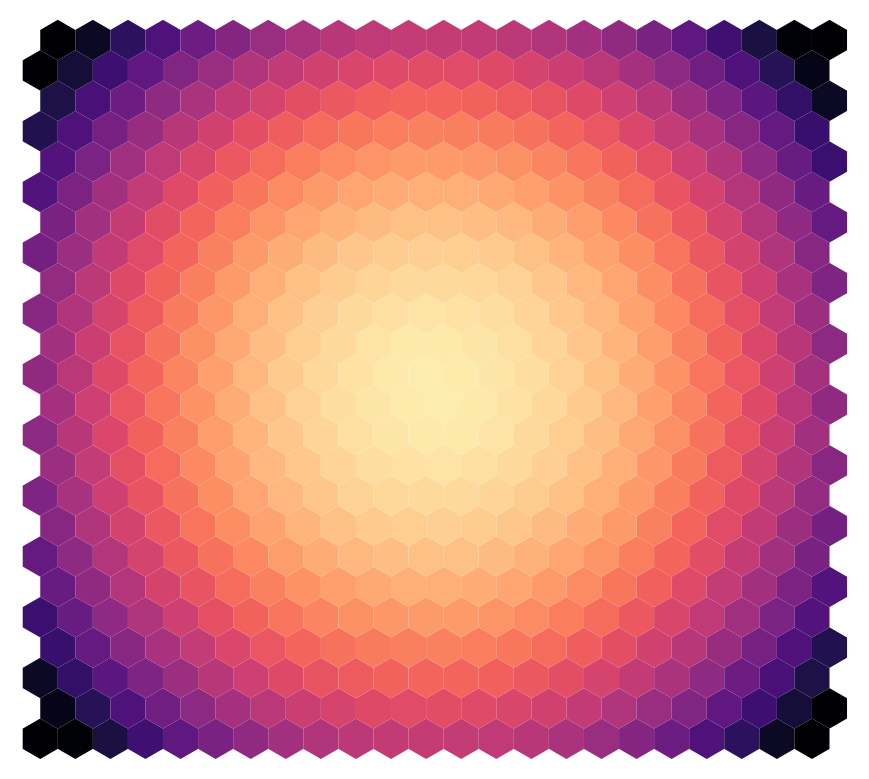

In [8]:
r = 0.6
cmap = matplotlib.colormaps['magma']
# counts = []
# for i in range(len(flux)): counts.append(np.sum(flux[i]))
norm = Normalize(vmin=np.percentile(v_near, 1), vmax=np.percentile(v_near, 90))

fig,ax=plt.subplots(1,1, dpi=100)
for x,y,i in zip(x_arr, y_arr, range(len(x_arr))):
    color = cmap(norm(v_near[i]) * 0.9)
    hexag = matplotlib.patches.RegularPolygon((x,y), numVertices=6, radius=r, facecolor=color)
    ax.add_patch(hexag)
    # ax.text(x, y, f'{i+1}', ha='center', va='center', fontsize=6, color='red')  # takes a long time, reduce hexagons to see numbers

ax.set_xlim(np.min(hex[:,0])-r, np.max(hex[:,0])+r)
ax.set_ylim(np.min(hex[:,1])-r, np.max(hex[:,1])+r)
ax.set_aspect('equal'); ax.invert_xaxis()
ax.set_axis_off()

In [16]:
ckm = 3e5 
def dopplershift(wl0, vel):
    return wl0 * (vel / ckm)

In [17]:
# vel in km/s
# ne is electron density in cm^-3

def getspectrum(wl, T, ne, lines, vel):
    wl = np.asarray(wl)
    
    spectrum = np.zeros_like(wl)
    info = []

    vel = vel * 1e5 # converting to cm/s

    for line in lines:
        ion = line['ion']
        lam0 = line['wl']
        mass = line['mass']
        ni = line.get('ni', 1e-4 * ne)

        # flux
        F = getflux(ion, lam0, T, ne, ni= ni)
    
        thermal = broaden(lam0, T, mass)

        # broadening from bulk motion
        doppler = lam0 * (vel / c)
        
        sigma = np.sqrt(thermal**2 + doppler**2)

        prof, amp = getgauss(wl, lam0, sigma, F)

        spectrum += prof
        info.append({
            'wl': lam0,
            'flux': F,
            'sigma': sigma,
            'amp': amp,
        })

    spectrum = np.array(spectrum)
    return spectrum, info


In [23]:
wl = np.linspace(4850, 5050, 5000)

idx = 100

shifts = dopplershift(5007.0, v_near)

T = 2600
ne = 30
vel = v_near[idx]

m_H = m_p
m_O = 16 * m_p

lines = [
    # {'ion': H1,  'wl': 4861, 'mass': m_H},
    {'ion': O3,  'wl': 4959, 'mass': m_O},
    {'ion': O3,  'wl': 5007, 'mass': m_O}]

spec, info = getspectrum(wl, T, ne, lines, vel)

In [24]:
hdul = fits.open('data/smc_snr/b0885.norm.dc.fits')
flux = hdul[0].data
hdr = hdul[0].header

if 'CD1_1' in hdr:
    wave = hdr['CRVAL1'] + hdr['CD1_1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)
else:
    wave = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)


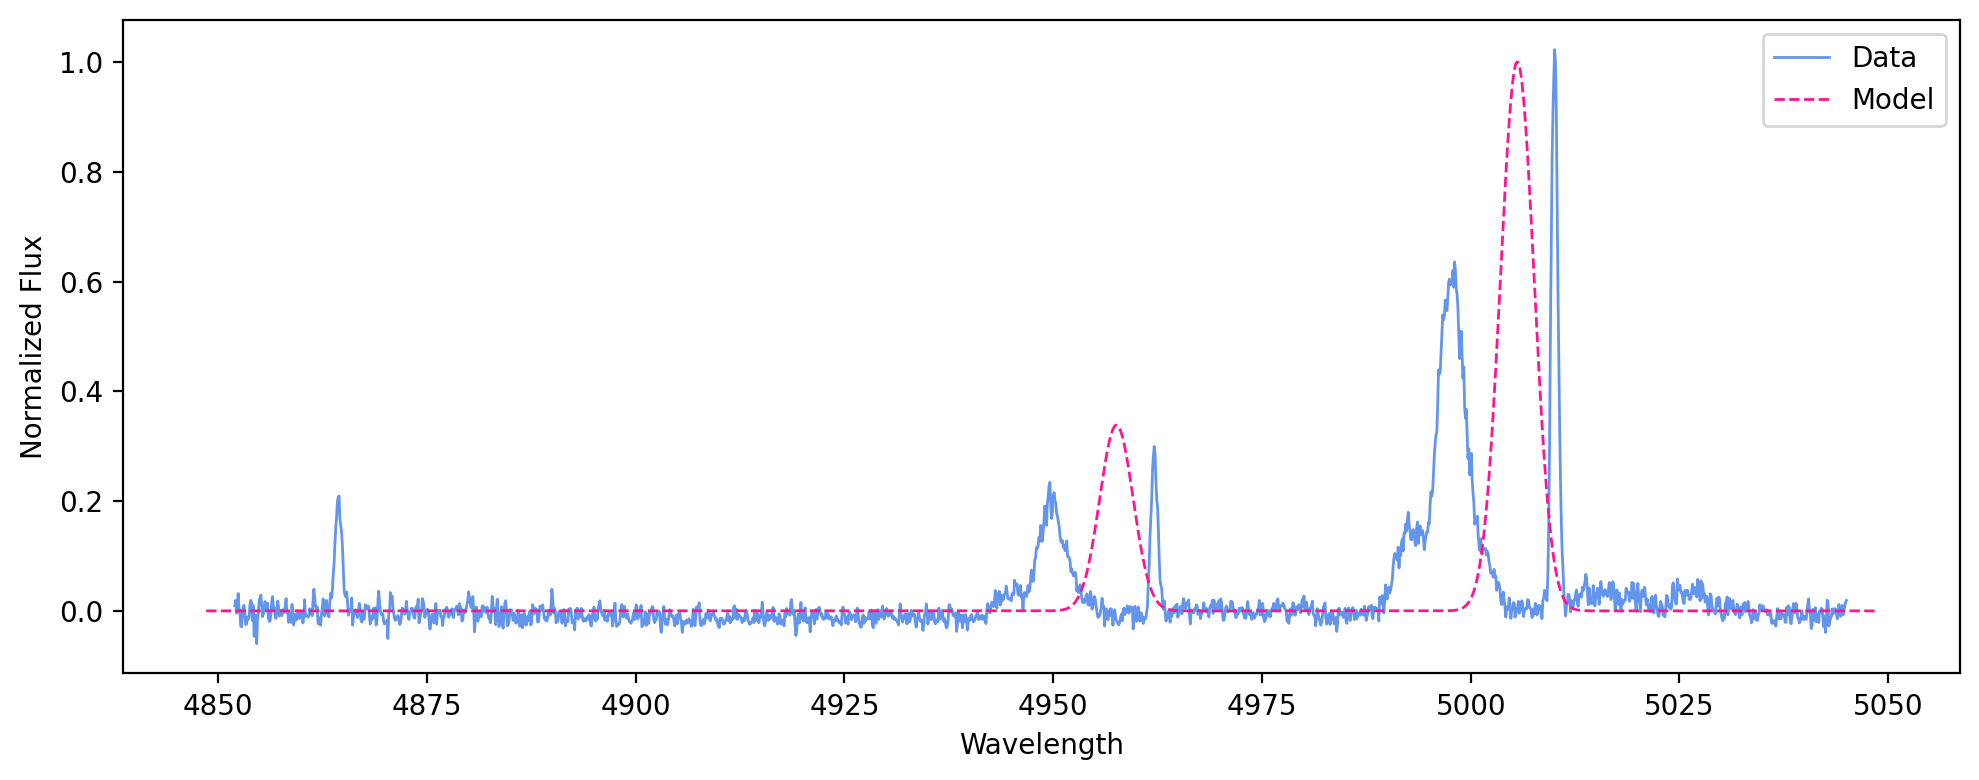

In [36]:
# z = (5010 - 5007) / 5007 # our data has offset, correcting for that
z = 0

plt.figure(figsize=(10,4))

plt.plot(wave, (flux[idx] - np.median(flux[idx])) / np.max(flux[0]), label='Data', lw = 1, color = 'cornflowerblue')

#plt.plot(wave / (1 + z), (flux[0] - np.median(flux[0])) / np.max(flux[0]), label='Data', lw = 1, color = 'cornflowerblue')


plt.plot(wl - shifts[idx], spec/np.max(spec), label='Model', color = 'deeppink', ls = '--', lw = 1)

# plt.plot(wl - shifts[idx] - 7, spec/np.max(spec), label='Model', color = 'deeppink', ls = '--', lw = 1)


plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.tight_layout()
